# Brain Tumor Classification and Segmentation
Kelompok 17: 
1. Kent Amadeo Timotheus - 2702227025
2. Theodore Zachary - 2702244100
3. Albertus Edbert Chandrajaya - 2702345440

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.filters import gabor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Dataset Preparation
## Dataset Gathering

In [18]:
DATA_PATH = 'data/'
TARGET_SIZE = (256, 256)

images = []
masks = []
labels = []

def z_score_normalize(image):
    mean = np.mean(image)
    std = np.std(image)
    return (image - mean) / std

def numeric_sort_key(fname): # function to sort filenames numerically
    nums = re.findall(r'\d+', fname)
    return tuple(map(int, nums)) if nums else (float('inf'), fname)

skip_image = False

for folder in os.listdir(DATA_PATH):
    label = folder
    folder_path = os.path.join(DATA_PATH, folder)
    
    idx = 0
    for image_file in sorted(os.listdir(folder_path), key=numeric_sort_key): 
        if idx < 400: # limit the number of images per class to 400
            image_path = os.path.join(folder_path, image_file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, TARGET_SIZE)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            img_zscore = z_score_normalize(gray)
            
            if image_file.endswith('_mask.png') and not skip_image:
                masks.append((gray > 127).astype(np.uint8)) # TODO: not yet accounting if the mask appears before image
                # print("DEBUG: Added mask for file:", image_file)
                idx += 1
            elif image_file.endswith('_mask.png') and skip_image:
                skip_image = False
                print(f"Warning: Skipping image {image_path} due to missing corresponding image.")
                continue
            elif image_file.replace('.png', '_mask.png') not in os.listdir(folder_path):
                skip_image = True
                continue
            else: # it's an image file
                image_norm = cv2.normalize(img_zscore, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX) # Z-Score Normalization with Min-Max Scaling
                images.append(image_norm)
                labels.append(label)
                # print("DEBUG: Added image and label for file:", image_file)
                # idx += 1
        else:
            break    
        
        
X = np.array(images)
M = np.array(masks)

encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(np.array(labels).reshape(-1, 1))

print(f'Images shape: {X.shape}')
print(f'Masks shape: {M.shape}')
print(f'Labels shape: {y.shape}')

Images shape: (1200, 256, 256)
Masks shape: (1200, 256, 256)
Labels shape: (1200, 3)


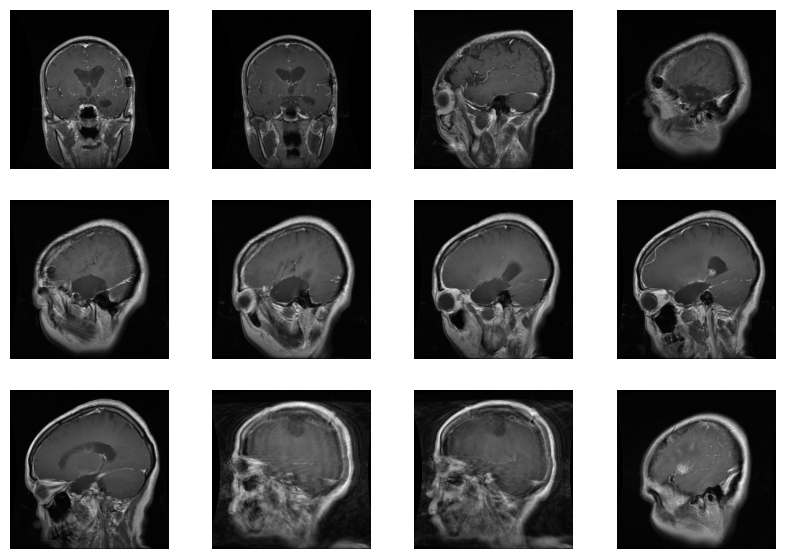

In [19]:
plt.figure(figsize=(10, 7))
for i in range(12):
    plt.subplot(3, 4, i+1) # i+1 because the index for matplotlib starts from 1, while i starts from 0
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

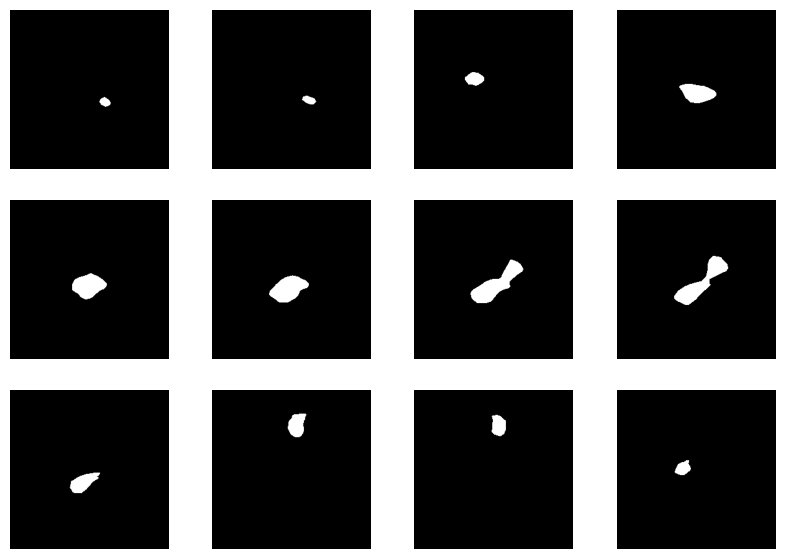

In [20]:
plt.figure(figsize=(10, 7))
for i in range(12):
    plt.subplot(3, 4, i+1) # i+1 because the index for matplotlib starts from 1, while i starts from 0
    plt.imshow(M[i], cmap="gray")
    plt.axis('off')
plt.show()

## Image Preprocessing

Split the data into training data, validation data, and testing data. In this case we will have a ratio of 70:15:15

In [21]:
stratify_labels = np.argmax(y, axis=1) # since the labels are already one-hot encoded
X_train, X_temp, y_train, y_temp, M_train, M_temp = train_test_split(X, y, M, test_size=0.3, random_state=42, stratify=stratify_labels)

stratify_temp = np.argmax(y_temp, axis=1)
X_val, X_test, y_val, y_test, M_val, M_test = train_test_split(X_temp, y_temp, M_temp, test_size=0.5, random_state=42, stratify=stratify_temp)

print(f'Training set: {X_train.shape}, {y_train.shape}, {M_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}, {M_val.shape}')
print(f'Testing set: {X_test.shape}, {y_test.shape}, {M_test.shape}')

Training set: (840, 256, 256), (840, 3), (840, 256, 256)
Validation set: (180, 256, 256), (180, 3), (180, 256, 256)
Testing set: (180, 256, 256), (180, 3), (180, 256, 256)


## Feature Extraction for Segmentation
Patch-based feature extraction

In [22]:
def glcm_features(patch, levels=256):
    # ensure integer gray levels required by graycomatrix
    if patch.dtype.kind == 'f':
        # assume floats are in [0,1]; scale to [0, levels-1]
        patch_scaled = np.clip(np.round(patch * (levels - 1)), 0, levels - 1).astype(np.uint8)
    else:
        # already integer type: clip to valid range
        patch_scaled = np.clip(patch, 0, levels - 1).astype(np.uint8)
    
    glcm = graycomatrix(
        patch_scaled,
        distances=[1],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=levels,
        symmetric=True,
        normed=True
    )
    
    eps = 1e-10
    # glcm shape: (levels, levels, n_distances, n_angles)
    p = glcm.copy()
    p = p / (p.sum(axis=(0,1), keepdims=True) + eps)  # per-slice normalization
    entropies = -np.sum(np.where(p > 0, p * np.log2(p), 0.0), axis=(0,1))  # shape: (n_distances, n_angles)
    entropy_mean = entropies.mean()
    
    feats = {
        'contrast': graycoprops(glcm, 'contrast').mean(),
        'correlation': graycoprops(glcm, 'correlation').mean(),
        'energy': graycoprops(glcm, 'energy').mean(),
        'homogeneity': graycoprops(glcm, 'homogeneity').mean(), 
        'entropy': entropy_mean
    }
    return feats

In [23]:
def lbp_features(patch, P=16, R=2):
    # P = number of neighbors, R = radius
    lbp = local_binary_pattern(patch, P, R, method='uniform')
    
    hist, _ = np.histogram(lbp.ravel(),
                           bins=np.arange(0, P+3),
                           range=(0, P+2))
    
    hist = hist.astype(float) / hist.sum() # normalize
    return hist

In [24]:
def gabor_features(patch, frequencies=[0.1, 0.2], thetas=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    feats = []
    
    for freq in frequencies:
        for theta in thetas:
            filt_real, filt_imag = gabor(patch, frequency=freq, theta=theta)
            feats.append(filt_real.mean())
            feats.append(filt_real.var())
    return feats

In [25]:
def spatial_features(x, y, img_shape):
    h, w = img_shape
    
    # coordinates (normalized)
    x_norm = x / w
    y_norm = y / h
    
    # Center coordinates
    x_c, y_c = w / 2, h / 2
    
    # Distance from center
    dist_center = np.sqrt((x - x_c)**2 + (y - y_c)**2) / np.sqrt((w/2)**2 + (h/2)**2)
    
    return [x_norm, y_norm, dist_center]

In [26]:
def extract_patch_features(img, x, y, patch_size=7): # patch-based feature extraction
    patch = img[x:x+patch_size, y:y+patch_size]
    
    # Intensity stats
    mean_intensity = patch.mean()
    var_intensity  = patch.var()
    
    # GLCM features
    glcm_feats = glcm_features(patch)
    
    # LBP features
    lbp_hist = lbp_features(patch)
    
    # Gabor features
    gabor_feats = gabor_features(patch)
    
    # Spatial features
    spatial_feats = spatial_features(x, y, img.shape)
    
    # combine all features
    feature_vector = [
        mean_intensity,
        var_intensity,
        glcm_feats['contrast'],
        glcm_feats['correlation'],
        glcm_feats['energy'],
        glcm_feats['homogeneity'],
        glcm_feats['entropy']
    ] + lbp_hist.tolist() + gabor_feats + spatial_feats
    
    return feature_vector

In [27]:
def balanced_patch_sampling(img, mask, patch_size=7, ratio=1.0):
    h, w = img.shape
    half = patch_size // 2
    padded_img = np.pad(img, pad_width=half, mode='reflect')

    # Collect tumor and background coordinates
    tumor_coords = [(x,y) for x in range(h) for y in range(w) if mask[x,y] == 1]
    bg_coords    = [(x,y) for x in range(h) for y in range(w) if mask[x,y] == 0]

    # Sample background before feature extraction
    n_tumor = len(tumor_coords)
    n_bg    = int(n_tumor * ratio)
    bg_sample = np.random.choice(len(bg_coords), n_bg, replace=False)
    bg_coords = [bg_coords[i] for i in bg_sample]

    # Combine coords
    coords = tumor_coords + bg_coords

    # Extract features only for sampled coords
    X, y = [], []
    for (x,y_) in coords:
        feats = extract_patch_features(padded_img, x+half, y_+half, patch_size)
        X.append(feats)
        y.append(mask[x,y_])

    return np.array(X), np.array(y)


In [28]:
def build_dataset_from_image(img, mask, patch_size=7): # patch-based feature extraction for every pixel (expensive)
    h, w = img.shape
    half = patch_size // 2

    # Global padding to handle border pixels
    padded_img = np.pad(img, pad_width=half, mode='reflect')
    padded_mask = np.pad(mask, pad_width=half, mode='reflect')

    X = []
    y = []

    # Slide over every pixel in the original image's range
    for x in range(h):
        for y_ in range(w):
            # Extract features from patch centered at (x, y)
            features = extract_patch_features(padded_img, x + half, y_ + half, patch_size) # + half shift to account for padding
            label = padded_mask[x + half, y_ + half] # ground-truth label from mask

            X.append(features)
            y.append(label)

    return np.array(X), np.array(y)

### Dataset Reconstruction

In [ ]:
X_all = []
M_all = []

for img, mask in zip(X_train, M_train):
    X_img, M_img = balanced_patch_sampling(img, mask)
    X_all.append(X_img)
    M_all.append(M_img)

# Final dataset
X_train = np.vstack(X_all)
M_train = np.hstack(M_all)

print(f'Final training dataset shape: {X_train.shape}, {M_train.shape}')

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_39636\1652743178.py:23: RuntimeWarning: divide by zero encountered in log2
  entropies = -np.sum(np.where(p > 0, p * np.log2(p), 0.0), axis=(0,1))  # shape: (n_distances, n_angles)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_39636\1652743178.py:23: RuntimeWarning: invalid value encountered in multiply
  entropies = -np.sum(np.where(p > 0, p * np.log2(p), 0.0), axis=(0,1))  # shape: (n_distances, n_angles)
c:\Users\LENOVO\anaconda3\envs\artificial_intelligence\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [ ]:
np.savez('train_data.npz', X_train=X_train, M_train=M_train)

In [ ]:
train = np.load('train_data.npz')
X_train, M_train = train['X_train'], train['M_train']

In [ ]:
X_all = []
M_all = []

for img, mask in zip(X_val, M_val):
    X_img, M_img = build_dataset_from_image(img, mask)
    X_all.append(X_img)
    M_all.append(M_img)

# Final dataset
X_val = np.vstack(X_all)
M_val = np.hstack(M_all)

print(f'Final training dataset shape: {X_val.shape}, {M_val.shape}')

np.savez('val_data.npz', X_val=X_val, M_val=M_val)

In [ ]:
val = np.load('val_data.npz')
X_val, M_val = val['X_val'], val['M_val']

In [ ]:
X_all = []
M_all = []

for img, mask in zip(X_test, M_test):
    X_img, M_img = build_dataset_from_image(img, mask)
    X_all.append(X_img)
    M_all.append(M_img)

# Final dataset
X_test = np.vstack(X_all)
M_test = np.hstack(M_all)

print(f'Final training dataset shape: {X_test.shape}, {M_test.shape}')

np.savez('test_data.npz', X_test=X_test, M_test=M_test)

In [ ]:
test = np.load('test_data.npz')
X_test, M_test = test['X_test'], test['M_test']

# Training
## Training Preparation

In [ ]:
rf_seg = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

## Training Process

In [ ]:
rf_seg.fit(X_train, y_train)

## Saving the Model

# Training Results

In [ ]:
y_val_pred = rf_seg.predict(X_val)

print("Pixel Accuracy:", accuracy_score(y_val, y_val_pred))
print("Dice/F1 Score:", f1_score(y_val, y_val_pred, average='weighted'))

# Prediction

In [ ]:
def segment_image(img, rf_model, patch_size=7): # function for segmenting a full image
    h, w = img.shape
    half = patch_size // 2
    padded_img = np.pad(img, pad_width=half, mode='reflect')

    features = []
    coords = []

    # Extract features for every pixel
    for x in range(h):
        for y in range(w):
            feats = extract_patch_features(padded_img, x+half, y+half, patch_size)
            features.append(feats)
            coords.append((x,y))

    # Predict labels
    preds = rf_model.predict(features)

    # Reconstruct mask
    mask_pred = np.zeros((h,w), dtype=np.uint8)
    for (x,y), p in zip(coords, preds):
        mask_pred[x,y] = p

    return mask_pred